In [ ]:
!pip install transformers #installing the necessary modules

In [ ]:
#importing necessary modules
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

In [ ]:
#openning and reading the datasets
eng_data = open('english_data.txt', 'r', encoding='utf8').readlines()
tr_data = open('turkish_data.txt', 'r', encoding='utf8').readlines()
eng_tr_data = open('eng_tr_data.txt', 'r', encoding='utf8').readlines()
tr_eng_data = open('tr_eng_data.txt','r', encoding='utf8').readlines()

In [ ]:
eng_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#loading the pre-trained tokenizer for the model
eng_model = BertModel.from_pretrained("bert-base-cased", output_hidden_states = True)
#loading the pre-trained English BERT model
eng_model.eval() #putting the model into evaluation mode rather than training

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
tr_tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-cased")
#loading the pre-trained tokenizer for the model
tr_model = BertModel.from_pretrained("dbmdz/bert-base-turkish-128k-cased", output_hidden_states = True)
#loading the pre-trained Turkish BERT (BERTurk) model
tr_model.eval() #putting the model into evaluation mode rather than training

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(128000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def get_contatenated_layer_tokens(token_embeddings):
  #a function for getting the concatenatation of the last 4 layers in the models
  #per token for generating a single word embedding
  token_vecs_cat = []

  for token in token_embeddings:
      cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
      #concatenating the last 4 token embeddings
      token_vecs_cat.append(cat_vec)
  return token_vecs_cat

In [ ]:
def get_token_embedding_tr(text, index):
  #a function for obtaining word embeddings for each token in Turkish

  marked_text = "[CLS] " + text + " [SEP]" #inserting the necessary tokens to the
  #beggining and end of sentence of processing according to the pre-training

  tokenized_text = tr_tokenizer.tokenize(marked_text) #tokenizing the text;
  #separating the text into largest subwords that exist in the vocabulary
  #of the model

  indexed_tokens = tr_tokenizer.convert_tokens_to_ids(tokenized_text)
  #mapping the token strings to the vocabulary indices

  segments_ids = [1] * len(tokenized_text)
  #identifying the sentence each token belongs to; since in our case there is
  #only one sentence we assign each token '1'

  tokens_tensor = torch.tensor([indexed_tokens]) #we convert all data into
  #pytorch tensors
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad(): #to avoid computing the graph at this process for
      #reduced memory concuption

      outputs = tr_model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2] #hidden states from all layers

  token_embeddings = torch.stack(hidden_states, dim=0) #converting hidden states
  #to torch tensors and merging everything into one torch tensor

  token_embeddings = torch.squeeze(token_embeddings, dim=1) #removing 'batches'
  #dimension

  token_embeddings = token_embeddings.permute(1,0,2) #switching 'layers' and
  #'tokens' dimensions

  token_vecs_cat = get_contatenated_layer_tokens(token_embeddings) #concatenating
  #last four layers to create a single word embedding

  return token_vecs_cat[index] #returning the word embedding for the word with
  #the given index

In [ ]:
def get_token_embedding_eng(text, index):
  #a function for obtaining word embeddings for each token in English

  marked_text = "[CLS] " + text + " [SEP]" #inserting the necessary tokens to the
  #beggining and end of sentence of processing according to the pre-training

  tokenized_text = eng_tokenizer.tokenize(marked_text) #tokenizing the text;
  #separating the text into largest subwords that exist in the vocabulary
  #of the model

  indexed_tokens = eng_tokenizer.convert_tokens_to_ids(tokenized_text)
  #mapping the token strings to the vocabulary indices

  segments_ids = [1] * len(tokenized_text)
  #identifying the sentence each token belongs to; since in our case there is
  #only one sentence we assign each token '1'

  tokens_tensor = torch.tensor([indexed_tokens]) #we convert all data into
  #pytorch tensors
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad(): #to avoid computing the graph at this process for
      #reduced memory concuption

      outputs = eng_model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2] #hidden states from all layers

  token_embeddings = torch.stack(hidden_states, dim=0) #converting hidden states
  #to torch tensors and merging everything into one torch tensor

  token_embeddings = torch.squeeze(token_embeddings, dim=1) #removing 'batches'
  #dimension

  token_embeddings = token_embeddings.permute(1,0,2) #switching 'layers' and
  #'tokens' dimensions

  token_vecs_cat = get_contatenated_layer_tokens(token_embeddings) #concatenating
  #last four layers to create a single word embedding

  return token_vecs_cat[index] #returning the word embedding for the word with
  #the given index

In [ ]:
engdata_eng = [] #the list that will store the cosine similarity of English homonym
#senses in English
engdata_tr = [] #the list that will store the cosine similarity of English homonym
#senses in Turkish
for i in range(len(eng_data)):
  line_eng = eng_data[i].replace('\n','').split('\t') #cleaning and  splitting the data
  line_tr = eng_tr_data[i].replace('\n','').split('\t')
  print(i, line_eng)
  embedding1_eng = get_token_embedding_eng(line_eng[0], int(line_eng[2].split('-')[0]))
  #getting the word embeddings for homonym senses in English
  embedding2_eng = get_token_embedding_eng(line_eng[1], int(line_eng[2].split('-')[1]))
  sim_eng = cosine(embedding1_eng, embedding2_eng) #calculating the cosine similarity
  #between word embeddings in English
  embedding1_tr = get_token_embedding_tr(line_tr[0], int(line_tr[2].split('-')[0]))
  #getting the word embeddings for homonym senses in Turkish
  embedding2_tr = get_token_embedding_tr(line_tr[1], int(line_tr[2].split('-')[1]))
  sim_tr = cosine(embedding1_tr, embedding2_tr) #calculating the cosine similarity
  #between word embeddings in Turkish
  engdata_eng.append(sim_eng)
  engdata_tr.append(sim_tr)

0 ['A Northern accent.', 'In ‘today’ the accent is on the second syllable.', '2-3']
1 ['The time has come for action if these beautiful animals are to survive.', '5 soldiers were killed in action.', '5-5']
2 ['Is that your home address?', 'The policy fails to address the needs of people on low incomes.', '4-4']
3 ['Ash from the volcano fell over a wide area.', 'Ash trees are located here.', '0-0']
4 ['She was laid up with severe back pain.', 'The man was refusing to go to the back of the queue.', '6-8']
5 ['Tourists often disturb the delicate balance of nature on the island.', 'I have to check my bank balance.', '5-6']
6 ['He kicked the ball into the net.', 'She met him at the ball.', '3-5']
7 ["I don't have much money in the bank at the end of the month.", 'We strolled along the river bank.', '7-5']
8 ['The area is full of restaurants and bars.', 'I will buy a chocolate bar.', '7-5']
9 ['The bark peels off in summer.', 'The dog gave a loud bark.', '1-5']
10 ['He always plays his stere

In [ ]:
trdata_eng = [] #the list that will store the cosine similarity of Turkish homonym
#senses in English
trdata_tr = [] #the list that will store the cosine similarity of Turkish homonym
#senses in Turkish
for i in range(len(tr_data)):
  line_tr = tr_data[i].replace('\n','').split('\t') #cleaning and splitting the data
  line_eng = tr_eng_data[i].replace('\n','').split('\t')
  print(i, line_tr)
  embedding1_tr = get_token_embedding_tr(line_tr[0], int(line_tr[2].split('-')[0]))
  #getting the word embeddings for homonym senses in Turkish
  embedding2_tr = get_token_embedding_tr(line_tr[1], int(line_tr[2].split('-')[1]))
  sim_tr = cosine(embedding1_tr, embedding2_tr) #calculating the cosine similarity
  #between word embeddings in Turkish
  embedding1_eng = get_token_embedding_eng(line_eng[0], int(line_eng[2].split('-')[0]))
  #getting the word embeddings for homonym senses in English
  embedding2_eng = get_token_embedding_eng(line_eng[1], int(line_eng[2].split('-')[1]))
  sim_eng = cosine(embedding1_eng, embedding2_eng) #calculating the cosine similarity
  #between word embeddings in English
  trdata_eng.append(sim_eng)
  trdata_tr.append(sim_tr)

0 ['Abam gelin olduğu vakit, tel taktığı vakit ben de tel takacağım.', 'Başında siperlikli şapkası, sırtında kalın kumaştan ceketi ve bacağında abadan yapılmış pantolonu vardı.', '0-9']
1 ['Ali Reis hiç başını kaldırmıyordu, mavi ağların üstüne yumulmuş, elleri mekik gibi işliyor, yırtık ağ yenilenerek ileride büyücek, çok mavi bir yığın oluyordu.', 'Yamalı çorap, patiska don, palandan bozma gocuk, pantolonu kısalmış, ağı yırtık, bilmem neresinden.', '6-9']
2 ['Akça kızlar sökün etti yurdundan.', 'Onun için bir an önce konuşalım altın, akça işini.', '0-7']
3 ['Ahmet Bey, dedi, kim olduğunuzu, akidenizi, kasabada, köylerde ne gibi faaliyet gösterdiğinizi biliyorum.', 'Ağızları ve elleri yaladıkları akideden kıpkırmızı bir hâlde geçiyorlardı.', '5-4']
4 ['Bu küçük alay sallana süzüle önümüzden geçti.', 'Yanlış anladığı meydana çıkınca bu aramızda bir alay oldu.', '2-7']
5 ['Cemal ne olduğunu anlamaya çalışırken bu sefer asker sordu ona, Mektepli misin, alaylı mı?', 'Sesi alaylı bir ahenk

In [ ]:
engdata_eng = np.array(engdata_eng) #converting similarity lists into numpy arrays
engdata_tr = np.array(engdata_tr)
stat = stats.ttest_ind(engdata_eng, engdata_tr) #conducting the two-tailed t-test
if stat[1] < 0.05: #the level of significance is 0.05
  print("significant result")
print("English mean for English homonym senses:", round(np.mean(engdata_eng),2))
print("Turkish mean for English homonym senses:", round(np.mean(engdata_tr),2))
print("English standard deviation for English homonym senses:", round(np.std(engdata_eng),2))
print("Turkish standard deviation for English homonym senses:", round(np.std(engdata_tr),2))
print("t-value", stat[0])
print("p-value", round(stat[1],3))

significant result
English mean for English homonym senses: 0.37
Turkish mean for English homonym senses: 0.7
English standard deviation for English homonym senses: 0.08
Turkish standard deviation for English homonym senses: 0.1
t-value -27.49265966968731
p-value 0.0


In [ ]:
q3_tr, q1_tr = np.percentile(engdata_tr, [75 ,25]) #calculating
#first and third quartile
q3_eng, q1_eng = np.percentile(engdata_eng, [75 ,25])
iqr_tr = q3_tr - q1_tr #calculating interquartile difference
iqr_eng = q3_eng - q1_eng
upper_tr = q3_tr + (1.5*iqr_tr) #calculating upper and lower quartile
lower_tr = q1_tr - (1.5*iqr_tr)
upper_eng = q3_eng + (1.5*iqr_eng)
lower_eng = q1_eng - (1.5*iqr_eng)

In [ ]:
filtered_engdata_tr = [] #the list that stores the data filtered from the outliers
filtered_engdata_eng = []
for i in range(len(engdata_tr)):
  if engdata_tr[i] > lower_tr and engdata_tr[i] < upper_tr: #checking if the value
  #is an outlier or not
    if engdata_eng[i] > lower_eng and engdata_eng[i] < upper_eng:
      filtered_engdata_tr.append(engdata_tr[i]) #if the value is not an outlier
      #save the value into the filtered list
      filtered_engdata_eng.append(engdata_eng[i])

In [ ]:
filtered_engdata_tr = np.array(filtered_engdata_tr) #converting similarity lists into numpy arrays
filtered_engdata_eng = np.array(filtered_engdata_eng)
stat = stats.ttest_ind(filtered_engdata_tr, filtered_engdata_eng) #conducting the two-tailed t-test
if stat[1] < 0.05: #the level of significance is 0.05
  print("significant result")
print("Turkish mean for English homonym senses:", round(np.mean(filtered_engdata_tr),2))
print("English mean for English homonym senses:", round(np.mean(filtered_engdata_eng),2))
print('Turkish max for English homonym senses:', round(np.max(filtered_engdata_tr),2))
print('Turkish min for English homonym senses:', round(np.min(filtered_engdata_tr),2))
print('English max for English homonym senses:', round(np.max(filtered_engdata_eng),2))
print('English min for English homonym senses:', round(np.min(filtered_engdata_eng),2))
print("Turkish standard deviation for English homonym senses:", round(np.std(filtered_engdata_tr),2))
print("English standard deviation for English homonym senses:", round(np.std(filtered_engdata_eng),2))
print("t-value", stat[0])
print("p-value", round(stat[1],3))

significant result
Turkish mean for English homonym senses: 0.7
English mean for English homonym senses: 0.37
Turkish max for English homonym senses: 0.96
Turkish min for English homonym senses: 0.45
English max for English homonym senses: 0.53
English min for English homonym senses: 0.23
Turkish standard deviation for English homonym senses: 0.1
English standard deviation for English homonym senses: 0.06
t-value 28.57292709283127
p-value 0.0


In [ ]:
trdata_tr = np.array(trdata_tr) #converting similarity lists into numpy arrays
trdata_eng = np.array(trdata_eng)
stat = stats.ttest_ind(trdata_tr, trdata_eng) #conducting the two-tailed t-test
if stat[1] < 0.05: #the level of significance is 0.05
  print("significant result")
print("Turkish mean for Turkish homonym senses:", round(np.mean(trdata_tr),2))
print("English mean for Turkish homonym senses:", round(np.mean(trdata_eng),2))
print("Turkish standard deviation for Turkish homonym senses:", round(np.std(trdata_tr),2))
print("English standard deviation for Turkish homonym senses:", round(np.std(trdata_eng),2))
print("t-value", stat[0])
print("p-value", round(stat[1],3))

significant result
Turkish mean for Turkish homonym senses: 0.73
English mean for Turkish homonym senses: 0.41
Turkish standard deviation for Turkish homonym senses: 0.1
English standard deviation for Turkish homonym senses: 0.08
t-value 27.612247962354008
p-value 0.0


In [ ]:
q3_tr, q1_tr = np.percentile(trdata_tr, [75 ,25]) #calculating
#first and third quartile
q3_eng, q1_eng = np.percentile(trdata_eng, [75 ,25])
iqr_tr = q3_tr - q1_tr #calculating interquartile difference
iqr_eng = q3_eng - q1_eng
upper_tr = q3_tr + (1.5*iqr_tr) #calculating upper and lower quartile
lower_tr = q1_tr - (1.5*iqr_tr)
upper_eng = q3_eng + (1.5*iqr_eng)
lower_eng = q1_eng - (1.5*iqr_eng)

In [ ]:
filtered_trdata_tr = [] #the list that stores the data filtered from the outliers
filtered_trdata_eng = []
for i in range(len(trdata_tr)):
  if trdata_tr[i] > lower_tr and trdata_tr[i] < upper_tr: #checking if the value
  #is an outlier or not
    if trdata_eng[i] > lower_eng and trdata_eng[i] < upper_eng:
      filtered_trdata_tr.append(trdata_tr[i]) #if the value is not an outlier
      #save the value into the filtered list
      filtered_trdata_eng.append(trdata_eng[i])

In [ ]:
filtered_trdata_tr = np.array(filtered_trdata_tr) #converting similarity lists into numpy arrays
filtered_trdata_eng = np.array(filtered_trdata_eng)
stat = stats.ttest_ind(filtered_trdata_tr, filtered_trdata_eng) #conducting the two-tailed t-test
if stat[1] < 0.05: #the level of significance is 0.05
  print("significant result")
print("Turkish mean for Turkish homonym senses:", round(np.mean(filtered_trdata_tr),2))
print("English mean for Turkish homonym senses:", round(np.mean(filtered_trdata_eng),2))
print('Turkish max for Turkish homonym senses:', round(np.max(filtered_trdata_tr),2))
print('Turkish min for Turkish homonym senses:', round(np.min(filtered_trdata_tr),2))
print('English max for Turkish homonym senses:', round(np.max(filtered_trdata_eng),2))
print('English min for Turkish homonym senses:', round(np.min(filtered_trdata_eng),2))
print("Turkish standard deviation for Turkish homonym senses:", round(np.std(filtered_trdata_tr),2))
print("English standard deviation for Turkish homonym senses:", round(np.std(filtered_trdata_eng),2))
print("t-value", stat[0])
print("p-value", round(stat[1],3))

significant result
Turkish mean for Turkish homonym senses: 0.75
English mean for Turkish homonym senses: 0.4
Turkish max for Turkish homonym senses: 0.89
Turkish min for Turkish homonym senses: 0.54
English max for Turkish homonym senses: 0.57
English min for Turkish homonym senses: 0.24
Turkish standard deviation for Turkish homonym senses: 0.07
English standard deviation for Turkish homonym senses: 0.06
t-value 36.785810107550034
p-value 0.0


In [ ]:
stat = stats.ttest_ind(filtered_engdata_eng, filtered_trdata_eng) #comparing
#English and Turkish homonym senses in English
if stat[1] < 0.05:
  print("significant result")
print("t-value", stat[0])
print("p-value", round(stat[1],3))

significant result
t-value -4.189687144088023
p-value 0.0


In [ ]:
stat = stats.ttest_ind(filtered_engdata_tr, filtered_trdata_tr) #comparing
#English and Turkish homonym senses in Turkish
if stat[1] < 0.05:
  print("significant result")
print("t-value", stat[0])
print("p-value", round(stat[1],3))

significant result
t-value -4.1233318638832035
p-value 0.0


The plots:

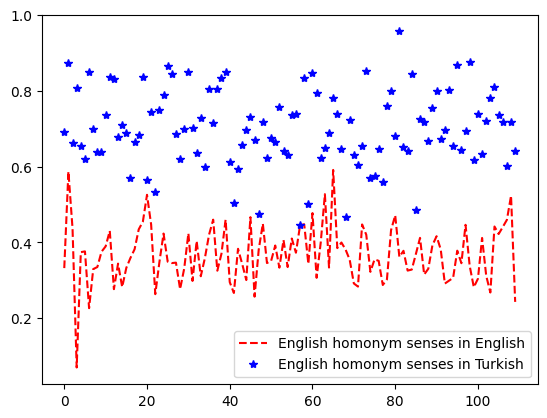

In [ ]:
plt.plot(engdata_eng, "r--", engdata_tr, "b*")
plt.legend(["English homonym senses in English", "English homonym senses in Turkish"])

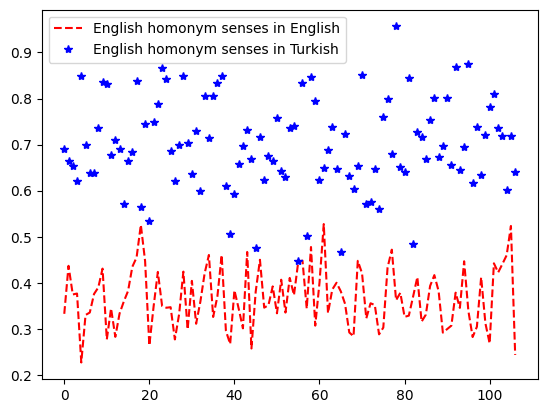

In [ ]:
plt.plot(filtered_engdata_eng, "r--", filtered_engdata_tr, "b*")
plt.legend(["English homonym senses in English", "English homonym senses in Turkish"])

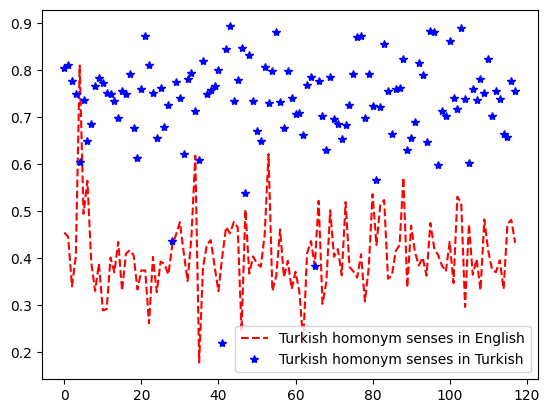

In [ ]:
plt.plot(trdata_eng, "r--", trdata_tr, "b*")
plt.legend(["Turkish homonym senses in English", "Turkish homonym senses in Turkish"])

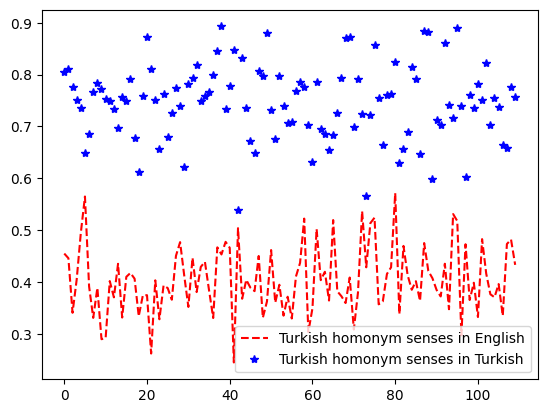

In [ ]:
plt.plot(filtered_trdata_eng, "r--", filtered_trdata_tr, "b*")
plt.legend(["Turkish homonym senses in English", "Turkish homonym senses in Turkish"])

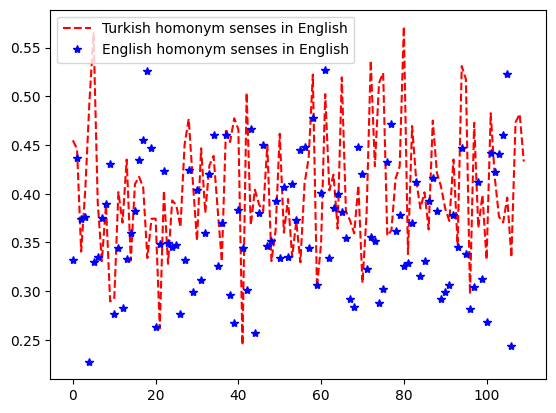

In [ ]:
plt.plot(filtered_trdata_eng, "r--", filtered_engdata_eng, "b*")
plt.legend(["Turkish homonym senses in English", "English homonym senses in English"])

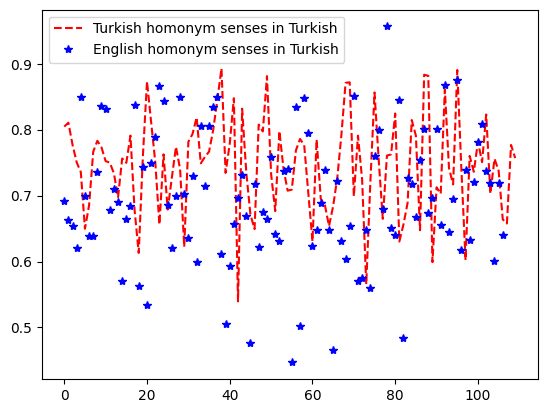

In [ ]:
plt.plot(filtered_trdata_tr, "r--", filtered_engdata_tr, "b*")
plt.legend(["Turkish homonym senses in Turkish", "English homonym senses in Turkish"])

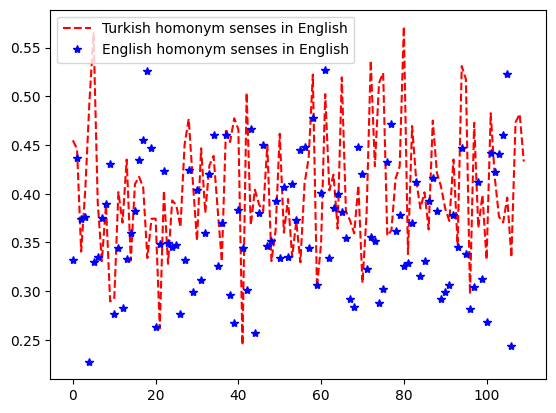

In [ ]:
plt.plot(filtered_trdata_eng, "r--", filtered_engdata_eng, "b*")
plt.legend(["Turkish homonym senses in English", "English homonym senses in English"])

In [ ]:
stats.pearsonr(filtered_engdata_eng, filtered_engdata_tr) #correlation analysis
#of similarities for English homonym senses

PearsonRResult(statistic=0.10708761730120528, pvalue=0.27226009631224946)

In [ ]:
stats.pearsonr(filtered_trdata_eng, filtered_trdata_tr) #correlation analysis
#of similarities for Turkish homonym senses

PearsonRResult(statistic=0.03104389971944149, pvalue=0.7474910332752173)